# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [112]:
from __future__ import print_function

import PIL.Image
from io import BytesIO
from IPython.display import Image, display

import numpy as np
import tensorflow as tf

from six.moves import cPickle as pickle
from six.moves import range
from six.moves.urllib.request import urlretrieve
#from six.moves import urllib
#from six.moves import xrange
from scipy import ndimage

import sys
import gzip
import os
import tempfile
import tarfile

from math import ceil

%matplotlib inline
import matplotlib.pyplot as plt


# Could not download dataset, site is down.
# from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
# data_dir = ''
# mnist = read_data_sets(data_dir, one_hot=True)

data_folder = './data'
last_percent_reported = None

### Your code implementation goes here.
### Feel free to use as many code cells as needed.

In [113]:
def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(data_root, url, filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser? ' + str(statinfo.st_size))
  return dest_filename

def maybe_extract(filename, num_classes, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) == 0:
    data_folders = [ root ]
  else:
    if len(data_folders) != num_classes:
      raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
    
  print("Folder: " + str(data_folders) + " - " + root)
  return data_folders

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
'''
def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
'''       
def maybe_pickle(data_folders, min_num_images_per_class, force, fun, *args):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      # fun( *args )
      # dataset = load_letter(folder, min_num_images_per_class)
      dataset = fun(folder, min_num_images_per_class, *args)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

## Load notMNIST pickle

In [114]:

pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset_org = save['train_dataset']
  train_labels_org = save['train_labels']
  valid_dataset_org = save['valid_dataset']
  valid_labels_org = save['valid_labels']
  test_dataset_org = save['test_dataset']
  test_labels_org = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset_org.shape, train_labels_org.shape)
  print('Validation set', valid_dataset_org.shape, valid_labels_org.shape)
  print('Test set', test_dataset_org.shape, test_labels_org.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


## Make data gray scale

In [115]:
image_size = 28
num_labels = 10 # +1 space label
num_channels = 1 # grayscale

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

def shuffle(data, labels):
    rnd = np.random.get_state()
    np.random.shuffle(data)
    np.random.set_state(rnd)
    np.random.shuffle(labels)

train_dataset, train_labels = reformat(train_dataset_org, train_labels_org)
valid_dataset, valid_labels = reformat(valid_dataset_org, valid_labels_org)
test_dataset, test_labels = reformat(test_dataset_org, test_labels_org)

shuffle(train_dataset, train_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)



Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [116]:


def accuracy(predictions, labels):
  #with tf.name_scope('accuracy'):
  #  with tf.name_scope('correct_prediction'):
  #      correct_prediction = tf.equal(np.argmax(predictions, 1), np.argmax(labels, 1))
  #  with tf.name_scope('accuracy'):
  #      accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  #tf.summary.scalar('accuracy', accuracy)
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

#  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
#          / predictions.shape[0])

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  return tf.Variable(shape)

def variable_summaries(var):
    with tf.name_scope('summaries'):
      mean = tf.reduce_mean(var)
      tf.summary.scalar('mean', mean)
      with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
      tf.summary.scalar('stddev', stddev)
      tf.summary.scalar('max', tf.reduce_max(var))
      tf.summary.scalar('min', tf.reduce_min(var))
      tf.summary.histogram('histogram', var)
        
def output_size_pool(input_size, conv_filter_size, pool_filter_size,
                         padding, conv_stride, pool_stride):
        if padding == 'same':
            output_1 = ceil(float(input_size) / float(conv_stride))
            pool_1 = ceil(output_1 / float(pool_stride))
            
            output_2 = ceil(pool_1 / float(conv_stride))
            pool_2 = ceil(output_2 / float(pool_stride))
            
            output_3 = ceil(pool_2 / float(conv_stride))
        
        elif padding == 'valid':
            output_1 = ceil(float(input_size - conv_filter_size) / float(conv_stride))
            pool_1 = ceil((output_1 - pool_filter_size) / float(pool_stride))
            
            output_2 = ceil((pool_1 - conv_filter_size) / float(conv_stride))
            pool_2 = ceil((output_2 - pool_filter_size) / float(pool_stride))
            
            output_3 = ceil((pool_2 - conv_filter_size) / float(conv_stride))
        else:
            return None

        return int(output_3)


## Create Computational graph

In [117]:
batch_size = 16
patch_size = 5

depth_1 = 16
depth_2 = depth_1 * 2
depth_3 = depth_2 * 3

#depth_1 = 4
#depth_2 = 8
#depth_3 = 12

num_hidden = 128 #64 #64
graph = tf.Graph()

with graph.as_default():
    
  final_image_size = output_size_pool(input_size=image_size,
                                        conv_filter_size=5, pool_filter_size=2,
                                        padding='same', conv_stride=1,
                                        pool_stride=2)

  conv1_w = weight_variable([patch_size, patch_size, num_channels, depth_1])
  conv1_b = bias_variable(tf.ones([depth_1]) / 10)

  conv2_w = weight_variable([patch_size, patch_size, depth_1, depth_2])
  conv2_b = bias_variable(tf.ones([depth_2]) / 10)

  conv3_w = weight_variable([patch_size, patch_size, depth_2, depth_3])
  conv3_b = bias_variable(tf.ones([depth_3]) / 10)

  fc_w = weight_variable([final_image_size * final_image_size * depth_3, num_hidden])
  fc_b = bias_variable(tf.ones([num_hidden]) / 10)

  logits1_weights = weight_variable([num_hidden, num_labels])
  logits1_biases = tf.Variable(tf.zeros([num_labels]) / 10)
    
  def conv_layer1(data, weights, biases):
    with tf.name_scope('conv_layer_1'):
        #with tf.name_scope('weights'):
        #  weights = weight_variable([patch_size, patch_size, num_channels, depth_1])
        #  variable_summaries(weights)
        #with tf.name_scope('biases'):
        #  biases = bias_variable(tf.ones([depth_1]) / 10)
        #  variable_summaries(biases)
        with tf.name_scope('conv'):
          conv = tf.nn.conv2d(data, weights, [1, 1, 1, 1], padding='SAME')
          tf.summary.histogram('conv', conv)
        with tf.name_scope('activation'):
          relu = tf.nn.relu(conv + biases)
          tf.summary.histogram('relu', relu)
        with tf.name_scope('polling'):
          polling = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
          tf.summary.histogram('polling', polling)
    return polling

  def conv_layer2(data, weights, biases):
    with tf.name_scope('conv_layer_2'):
        #with tf.name_scope('weights'):
        #  weights = weight_variable([patch_size, patch_size, depth_1, depth_2])
        #  variable_summaries(weights)
        #with tf.name_scope('biases'):
        #  biases = bias_variable(tf.ones([depth_2]) / 10)
        #  variable_summaries(biases)
        with tf.name_scope('conv'):
          conv = tf.nn.conv2d(data, weights, [1, 1, 1, 1], padding='SAME')
          tf.summary.histogram('conv', conv)
        with tf.name_scope('activation'):
          relu = tf.nn.relu(conv + biases)
          tf.summary.histogram('relu', relu)
        with tf.name_scope('polling'):
          polling = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
          tf.summary.histogram('polling', polling)
    return polling

  def conv_layer3(data, weights, biases):
    with tf.name_scope('conv_layer_3'):
        #with tf.name_scope('weights'):
        #  weights = weight_variable([patch_size, patch_size, depth_2, depth_3])
        #  variable_summaries(weights)
        #with tf.name_scope('biases'):
        #  biases = bias_variable(tf.ones([depth_3]) / 10)
        #  variable_summaries(biases)
        with tf.name_scope('conv'):
          conv = tf.nn.conv2d(data, weights, [1, 1, 1, 1], padding='SAME')
          tf.summary.histogram('conv', conv)
        with tf.name_scope('activation'):
          relu = tf.nn.relu(conv + biases)
          tf.summary.histogram('relu', relu)
    return relu

  def full_conn(data, weights, biases, keep_prob):
    with tf.name_scope('full_conn'):
        #with tf.name_scope('weights'):
        #  weights = weight_variable([final_image_size * final_image_size * depth_3, num_hidden])
        #  variable_summaries(weights)
        #with tf.name_scope('biases'):
        #  biases = bias_variable(tf.ones([num_hidden]) / 10)
        #  variable_summaries(biases)
        with tf.name_scope('dropout'):
          dropout = tf.nn.dropout(data, keep_prob)
          tf.summary.histogram('dropout', dropout)
        with tf.name_scope('Wx_plus_b'):
          shape = dropout.get_shape().as_list()
          reshape = tf.reshape(dropout, [shape[0], shape[1] * shape[2] * shape[3]])
          preactivate  = tf.matmul(reshape, weights)
          tf.summary.histogram('pre_activation', preactivate )
        with tf.name_scope('activation'):
          relu = tf.nn.relu(preactivate  + biases)
          tf.summary.histogram('relu', relu)
    return relu

  def conv_layer1_1(data, wlayer1, blayer1):
    #if  patch_size == 5:
    #    print "patch"
    #if num_channels == 1:
    #    print "chanel"
    #if depth_1 == 16:
    #    print "depth"
    #wlayer1 = tf.get_variable("w1", tf.truncated_normal(
    #  [patch_size, patch_size, num_channels, depth_1], stddev=0.1))
    #blayer1 = tf.Variable(tf.zeros([depth_1]))
    with tf.name_scope('conv_layer_1_1'):
        with tf.name_scope('weights'):
          weights = weight_variable([patch_size, patch_size, num_channels, depth_1])
          #variable_summaries(weights)
        with tf.name_scope('biases'):
          biases = bias_variable(tf.ones([depth_1]) / 10)
          #variable_summaries(biases)
        with tf.name_scope('conv'):
          conv = tf.nn.conv2d(data, weights, [1, 2, 2, 1], padding='SAME')
        with tf.name_scope('relu'):
            hidden = tf.nn.relu(conv + biases)
    
    #conv = tf.nn.conv2d(data, weights, [1, 2, 2, 1], padding='SAME')
    #relu = tf.nn.relu(conv + biases)
    return hidden

  def conv_layer2_1(data):
    weights = weight_variable([patch_size, patch_size, depth_1, depth_1])    
    biases = bias_variable(tf.zeros([depth_1]))
    
    
    conv = tf.nn.conv2d(data, weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + biases)
    
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth_1, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    
    return hidden


    
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth_1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth_1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth_1, depth_1], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth_1]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth_1, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  


  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))

  #keep_prob = tf.placeholder(tf.float32)

  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
    
  
    
    
  '''
  # Variables.
  layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth_1])
  # layer1_biases = tf.Variable(tf.zeros([depth_1]))# tf.Variable(tf.constant(0.1, shape=[depth_1])) # tf.zeros([depth]))
  layer1_biases = tf.Variable(tf.ones([depth_1]) / 10)
  variable_summaries(layer1_weights)

  layer2_weights = weight_variable([patch_size, patch_size, depth_1, depth_2])
  #layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]))
  layer2_biases = tf.Variable(tf.ones([depth_2]) / 10);
  variable_summaries(layer2_weights)

  layer3_weights = weight_variable([patch_size, patch_size, depth_2, depth_3])
  # layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]))
  layer3_biases = tf.Variable(tf.ones([depth_3]) / 10);
  variable_summaries(layer3_weights)

  final_image_size = output_size_pool(input_size=image_size,
                                        conv_filter_size=5, pool_filter_size=2,
                                        padding='same', conv_stride=1,
                                        pool_stride=2)
    

  layer4_weights = weight_variable([final_image_size * final_image_size * depth_3, num_hidden])
  #layer4_weights = weight_variable([image_size // 4 * image_size // 4 * depth_1, num_hidden])
  # layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_biases = tf.Variable(tf.ones([num_hidden]) / 10)
  variable_summaries(layer4_weights)
  
  logits1_weights = weight_variable([num_hidden, num_labels])
  logits1_biases = tf.Variable(tf.zeros([num_labels]) / 10)
  variable_summaries(logits1_weights)
  # logits1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    

  logits2_weights = weight_variable([num_hidden, num_labels])
  logits2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  logits3_weights = weight_variable([num_hidden, num_labels])
  logits3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  logits4_weights = weight_variable([num_hidden, num_labels])
  logits4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  logits5_weights = weight_variable([num_hidden, num_labels])
  logits5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # conv 1
    # conv_1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    # hidden_relu_1 = tf.nn.relu(conv_1 + layer1_biases)
    # hidden_polling_1 = tf.nn.max_pool(hidden_relu_1, ksize=[1, 2, 2, 1],
    #                     strides=[1, 2, 2, 1], padding='SAME')
    # tf.summary.histogram('conv_1', conv_1)
    #conv_2 = tf.nn.conv2d(hidden_polling_1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    #hidden_relu_2 = tf.nn.relu(conv_2 + layer2_biases)
    #hidden_polling_2 = tf.nn.max_pool(hidden_relu_2, ksize=[1, 2, 2, 1],
    #                    strides=[1, 2, 2, 1], padding='SAME')
    #
    #conv_3 = tf.nn.conv2d(hidden_polling_2, layer3_weights, [1, 1, 1, 1], padding='SAME')
    #hidden_relu_3 = tf.nn.relu(conv_3 + layer3_biases)
    # fc
    #dropout_3 = tf.nn.dropout(hidden_relu_3, keep_prob)
    #shape = dropout_3.get_shape().as_list()    
    #reshape = tf.reshape(dropout_3, [shape[0], shape[1] * shape[2] * shape[3]])
    #hidden_fc = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    #logits_2 = tf.matmul(hidden_fc, logits2_weights) + logits2_biases
    #logits_3 = tf.matmul(hidden_fc, logits3_weights) + logits3_biases
    #logits_4 = tf.matmul(hidden_fc, logits4_weights) + logits4_biases
    #logits_5 = tf.matmul(hidden_fc, logits5_weights) + logits5_biases
    
  '''


  # Model.
  def model(data, keep_prob):
    conv_1 = conv_layer1(data, conv1_w, conv1_b)
    conv_2 = conv_layer2(conv_1, conv2_w, conv2_b)
    conv_3 = conv_layer3(conv_2, conv3_w, conv3_b)
    fc = full_conn(conv_3, fc_w, fc_b, keep_prob)
    logits_1 = tf.matmul(fc, logits1_weights) + logits1_biases
    
    '''
    conv_1 = conv_layer1_1(data)
    fc = conv_layer2_1(conv_1)
    
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    logits_1 = tf.matmul(fc, layer4_weights) + layer4_biases
    '''
    return logits_1 #[logits_1, logits_2, logits_3, logits_4, logits_5]
  
  def model2(data, keep_prob):
    #conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    #hidden = tf.nn.relu(conv + layer1_biases)
    
    hidden = conv_layer1_1(data, layer1_weights, layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    
  # Training computation.
  logits_1 = model(tf_train_dataset, 0.5) # , logits_2, logits_3, logits_4, logits_5
  
  #with tf.name_scope('loss'):
  #  diff = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_1)
  #  with tf.name_scope('total'):
  #    loss = tf.reduce_mean(diff)
  #
  #tf.summary.scalar('loss', loss)  

  step = tf.Variable(0, trainable=False)
  start_learning_rate = 0.05
  learning_rate = tf.train.exponential_decay(start_learning_rate, step, 1000, 0.96, staircase=True) 
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_1))
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=step)

  #with tf.name_scope('train'):
  #  #step = tf.Variable(0)
  #  #learning_rate = tf.train.exponential_decay(0.05, step, 100000, 0.96, staircase=True) 
  #  learning_rate=0.05
  #  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) #, global_step=step)

  train_prediction = tf.nn.softmax(model(tf_train_dataset, 1.0)) # multi_softmax(tf_train_dataset) #tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0)) # multi_softmax(tf_valid_dataset) #tf.nn.softmax(model(tf_valid_dataset))
  test_prediction =  tf.nn.softmax(model(tf_test_dataset, 1.0)) # multi_softmax(tf_test_dataset) #tf.nn.softmax(model(tf_test_dataset))

  tf_acc = 100 * tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(train_prediction, 1), tf.argmax(tf_train_labels, 1))))

  saver = tf.train.Saver()

In [119]:
num_steps = 3000 # 12500 # 
'''
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
'''
history = [(0, np.nan, 10)]
with tf.Session(graph=graph) as session:
  #summaries_dir = './simple'
  #merged = tf.summary.merge_all()
  #train_writer = tf.summary.FileWriter(summaries_dir + '/train',
  #                                   session.graph)
  #test_writer = tf.summary.FileWriter(summaries_dir + '/test')
   
  tf.global_variables_initializer().run()
  
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    feed_dict = {
        tf_train_dataset : batch_data,
        tf_train_labels : batch_labels
    }
    _, l, acc, predictions = session.run(
      [optimizer, loss, tf_acc, train_prediction], feed_dict=feed_dict)
    
    # train_writer.add_summary(summary)
    
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
      
      history.append((step, l, acc))
  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  save_path = saver.save(session, "./model/model_simple.ckpt")
  print('Model saved to ' + save_path)

# 1. Test accuracy: 89.8%
# 2. Test accuracy: 90.4%
# 3. Test accuracy: 89.6% / 90%

# 1. Test accuracy: 89.7%
# 2. Test accuracy: 90.1%
# 3. Test accuracy: 90.0%
# 4. Test accuracy: 91.4%
# 5. Test accuracy: 90.5%
# 6. Test accuracy: 91.3%
# 7. Test accuracy: 90.9%
# 8. Test accuracy: 92.3%
# 9. Test accuracy: 93.8%


Initialized
Minibatch loss at step 0: 5.528537
Minibatch accuracy: 12.5%
Validation accuracy: 10.1%
Minibatch loss at step 100: 1.090744
Minibatch accuracy: 56.2%
Validation accuracy: 68.0%
Minibatch loss at step 200: 0.559920
Minibatch accuracy: 81.2%
Validation accuracy: 78.2%
Minibatch loss at step 300: 0.869954
Minibatch accuracy: 75.0%
Validation accuracy: 78.6%
Minibatch loss at step 400: 0.491495
Minibatch accuracy: 87.5%
Validation accuracy: 80.9%
Minibatch loss at step 500: 0.114709
Minibatch accuracy: 100.0%
Validation accuracy: 81.6%
Minibatch loss at step 600: 0.637048
Minibatch accuracy: 81.2%
Validation accuracy: 81.6%
Minibatch loss at step 700: 0.778187
Minibatch accuracy: 81.2%
Validation accuracy: 82.7%
Minibatch loss at step 800: 0.576036
Minibatch accuracy: 81.2%
Validation accuracy: 83.4%
Minibatch loss at step 900: 0.874057
Minibatch accuracy: 81.2%
Validation accuracy: 83.5%
Minibatch loss at step 1000: 0.128419
Minibatch accuracy: 100.0%
Validation accuracy: 83.

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 
I took notMNIST dataset and created 3 convolution layers with pooling. After last convolution layer I do dropping. As optimization I use gradient descent and do decay on learning rate.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**
1. Input [16, 28, 28, 1]
2. Convolution Layer 1: Weight shape [5, 5, 1, 16], Bias shape [16], Stride [1, 1, 1, 1], Padding = 'SAME'
3. Activation RELU
4. Max Pool: Window [1, 2, 2, 1], Stride [1, 2, 2, 1], Padding = 'SAME'
5. Convolution Layer 2: Weight shape [5, 5, 16, 32], Bias shape [32]
6. Activation RELU
7. Max Pool: Window [1, 2, 2, 1], Stride [1, 2, 2, 1], Padding = 'SAME'
8. Convolution Layer 3: Weight shape [5, 5, 32, 96], Bias shape [96]
9. Activation RELU
10. Dropout: Keep prob 0.5
11. Reshape and multiply weight shape [full * full * 96, 128]
12. Activation RELU: Bias shape [128]
13. Logist: Weight shape [128, 10], Bias shape: [10]
14. Learning rate start 0.05 and decay
15. Softtmax cross entropy
16. Gradient descent optimizer



### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**
I do mini batches. 16 samples each time, repeat 3000 steps. Decay every 500 steps with a base of 0.96:

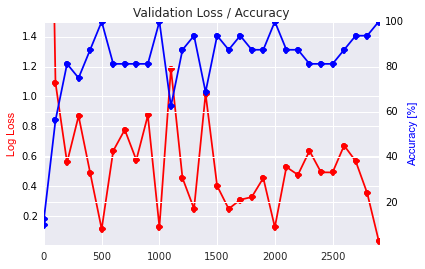

In [120]:
steps, loss, acc = zip(*history)

fig = plt.figure()
plt.title('Validation Loss / Accuracy')
ax_loss = fig.add_subplot(111)
ax_acc = ax_loss.twinx()
plt.xlabel('Training Steps')
plt.xlim(0, max(steps))

ax_loss.plot(steps, loss, '-o', color='red')
ax_loss.set_ylabel('Log Loss', color='red');
ax_loss.tick_params('y', colors='black')
ax_loss.set_ylim(0.01, 1.5)

ax_acc.plot(steps, acc, '-o', color='blue')
ax_acc.set_ylabel('Accuracy [%]', color='blue');
ax_acc.tick_params('y', colors='black')
ax_acc.set_ylim(1,100)

plt.show()

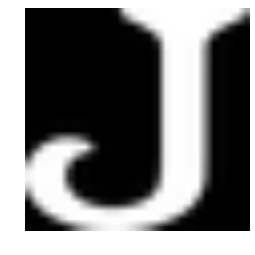

In [121]:
plt.axis('off')

imgplot1 = plt.imshow(train_dataset_org[1], cmap='gray')


#imgplot2 = plt.imshow(train_dataset_org[2], cmap='gray')

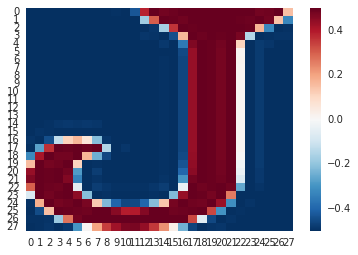

In [122]:
import seaborn as sns

sns.heatmap(train_dataset_org[1]) #test_cnt-1,:].reshape(28,28)

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

dd



In [123]:
url = 'http://ufldl.stanford.edu/housenumbers/'
#image_size = 28  # Pixel width and height.
#pixel_depth = 255.0  # Number of levels per pixel.
import h5py
import PIL.Image as Image

def struct_val(struct, attr):
    if (len(attr) > 1):
        attr = [struct[attr.value[j].item()].value[0] for j in range(len(attr))]
    else:
        attr = [attr.value[0]]
    return attr

def str_val(struct, attr):
    return ''.join([chr(c[0]) for c in struct[ attr[0] ].value])

def load_pic(folder, min_num_images, image_size, pixel_depth):
  """Load the data for a single letter label."""
  struct_file = os.path.join(folder, 'digitStruct.mat')
  struct = h5py.File(struct_file, 'r')
  names = struct['digitStruct']['name']
  bboxs = struct['digitStruct']['bbox']
  data = []

  dataset = []
  labels = []

  for i in range(len(names)):
    # ''.join( struct_val( struct, struct[ names[i][0] ] ) ) #
    name = str_val(struct, names[i]) # ''.join([chr(c[0]) for c in struct[ names[i][0] ].value])
    box = bboxs[i].item()
    
    bb = struct[box]
    struct_width  = struct_val(struct, bb["width"])
    struct_height = struct_val(struct, bb["height"])
    struct_label = struct_val(struct, bb["label"])
    struct_top = struct_val(struct, bb["top"])
    struct_left = struct_val(struct, bb["left"])
    
    label = [ 0 ]
    width = []
    height = []
    top = []
    left = []
    
    for j in range(len(struct_label)):
        for k in range(len(struct_label[j])):   
            width.append( struct_width[j][k] )
            height.append( struct_height[j][k] )
            top.append( struct_top[j][k] )
            left.append( struct_left[j][k] )
            
            if struct_label[j][k] == 10:
                label.append(0)
            else:
                label.append(struct_label[j][k])

    label[0] = len(width)
    labels.append(label)

    im_top = np.amin(top)
    im_left = np.amin(left)
    im_height = np.amax(top) + height[np.argmax(top)] - im_top
    im_width = np.amax(left) + width[np.argmax(left)] - im_left

    fullname = os.path.join(folder, name)
    img = Image.open(fullname)
    
    im_top = np.floor(im_top - 0.1 * im_height)
    im_left = np.floor(im_left - 0.1 * im_width)
    im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), img.size[1]])
    im_right = np.amin([np.ceil(im_left + 1.2 * im_width), img.size[0]])

    # print(fullname + ': ' + str(im_left) + ', ' + str(im_top) + ', ' + str(im_right) + ', ' + str(im_bottom))
    img = img.crop((int(im_left), int(im_top), int(im_right), int(im_bottom))).resize([32,32], Image.ANTIALIAS)
    im = np.dot(np.array(img, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
    mean = np.mean(im, dtype='float32')
    std = np.std(im, dtype='float32', ddof=1)
    if std < 1e-4: std = 1.
    im = (im - mean) / std
    dataset.append( im[:,:,:] )

    
  return [ dataset, labels ]
            
train_filename = maybe_download(data_folder, url, 'train.tar.gz', 404141560)
test_filename = maybe_download(data_folder, url, 'test.tar.gz', 276555967)
extra_filename = maybe_download(data_folder, url, 'extra.tar.gz', 1955489752)

train_folders = maybe_extract(train_filename, 0)
test_folders = maybe_extract(test_filename, 0)
extra_folders = maybe_extract(extra_filename, 0)

train_datasets = maybe_pickle(train_folders, 45000, False, load_pic, 32, 255.0)
test_datasets = maybe_pickle(test_folders, 1800, False, load_pic, 32, 255.0)
extra_folders = maybe_pickle(extra_folders, 1800, False, load_pic, 32, 255.0)

Found and verified ./data/train.tar.gz
Found and verified ./data/test.tar.gz
Found and verified ./data/extra.tar.gz
./data/train already present - Skipping extraction of ./data/train.tar.gz.
Folder: ['./data/train'] - ./data/train
./data/test already present - Skipping extraction of ./data/test.tar.gz.
Folder: ['./data/test'] - ./data/test
./data/extra already present - Skipping extraction of ./data/extra.tar.gz.
Folder: ['./data/extra'] - ./data/extra
./data/train.pickle already present - Skipping pickling.
./data/test.pickle already present - Skipping pickling.
./data/extra.pickle already present - Skipping pickling.


In [134]:
#from scipy.io import loadmat
#house_train_file = loadmat('svhn/train_32x32.mat')
#house_test_file = loadmat('svhn/test_32x32.mat')
#.astype(np.float32)

def read_pickle(pickle_file):
    with open(pickle_file, 'rb') as f:
        dataset = pickle.load(f)

    data = np.ndarray([len(dataset[0]),32,32,1], dtype='float32')
    labels = np.ones([len(dataset[0]),6], dtype=int) * 10
    
    k = 0
    for i in range(len(dataset[0])):
        if len(dataset[1][i]) <= 6:
            data[k] = dataset[0][i]
            for d in range(len(dataset[1][i])):
                labels[k][d] = dataset[1][i][d]
            # labels[k] = np.resize( np.array(dataset[1][i], dtype=int), 6 )
            #data[k,:,:,:] = dataset[0][i,:,:,:]
            #labels[k,:] = dataset[1][i,:]
            k += 1
    
    for i in range(len(dataset[0]) - k):
        data = np.delete(data, k + i, 0)
        labels = np.delete(labels, k + i, 0)
   
    return [ data, labels ]

#def reformat(data):
#    result = np.empty([len(data[0][0][0]), 32, 32, 1], dtype='float32')
#    for i in xrange(len(data[0][0][0])):
#        for x in xrange(32):
#            for y in xrange(32):
#                summ = 0
#                for c in xrange(3):                
#                    summ += data[x][y][c][i]
#                result[i][x][y][0] = summ / (255*3.0) 
#            
#    return result

train_dataset = read_pickle('./data/train.pickle')
test_dataset = read_pickle('./data/test.pickle')
extra_dataset = read_pickle('./data/extra.pickle')

# print(train_dataset.shape, train_dataset.shape)

#train_dataset_size = 30000
#test_datase_size = int( train_dataset_size * 0.1 ) 

#print("size " + str(train_dataset[1][0]))
#np.reshape(a, (2, 3))

house_train_dataset_org = train_dataset[0]
house_train_labels_org = train_dataset[1]

house_test_dataset_org = test_dataset[0]
house_test_labels_org = test_dataset[1]

house_valid_dataset_org = extra_dataset[0][: len(house_test_dataset_org)]
house_valid_labels_org = extra_dataset[1][: len(house_test_dataset_org)]

#house_test_dataset_org = house_test_dataset_org[len(house_test_dataset_org)/2:]
#house_test_labels_org = house_test_labels_org[len(house_test_labels_org)/2:]

#del house_train_file
#del house_test_file 

print('Training set', house_train_dataset_org.shape, house_train_labels_org.shape)
print('Validation set', house_valid_dataset_org.shape, house_valid_labels_org.shape)
print('Test set', house_test_dataset_org.shape, house_test_labels_org.shape)

Training set (33401, 32, 32, 1) (33401, 6)
Validation set (13068, 32, 32, 1) (13068, 6)
Test set (13068, 32, 32, 1) (13068, 6)


[ 2  1  9 10 10 10]


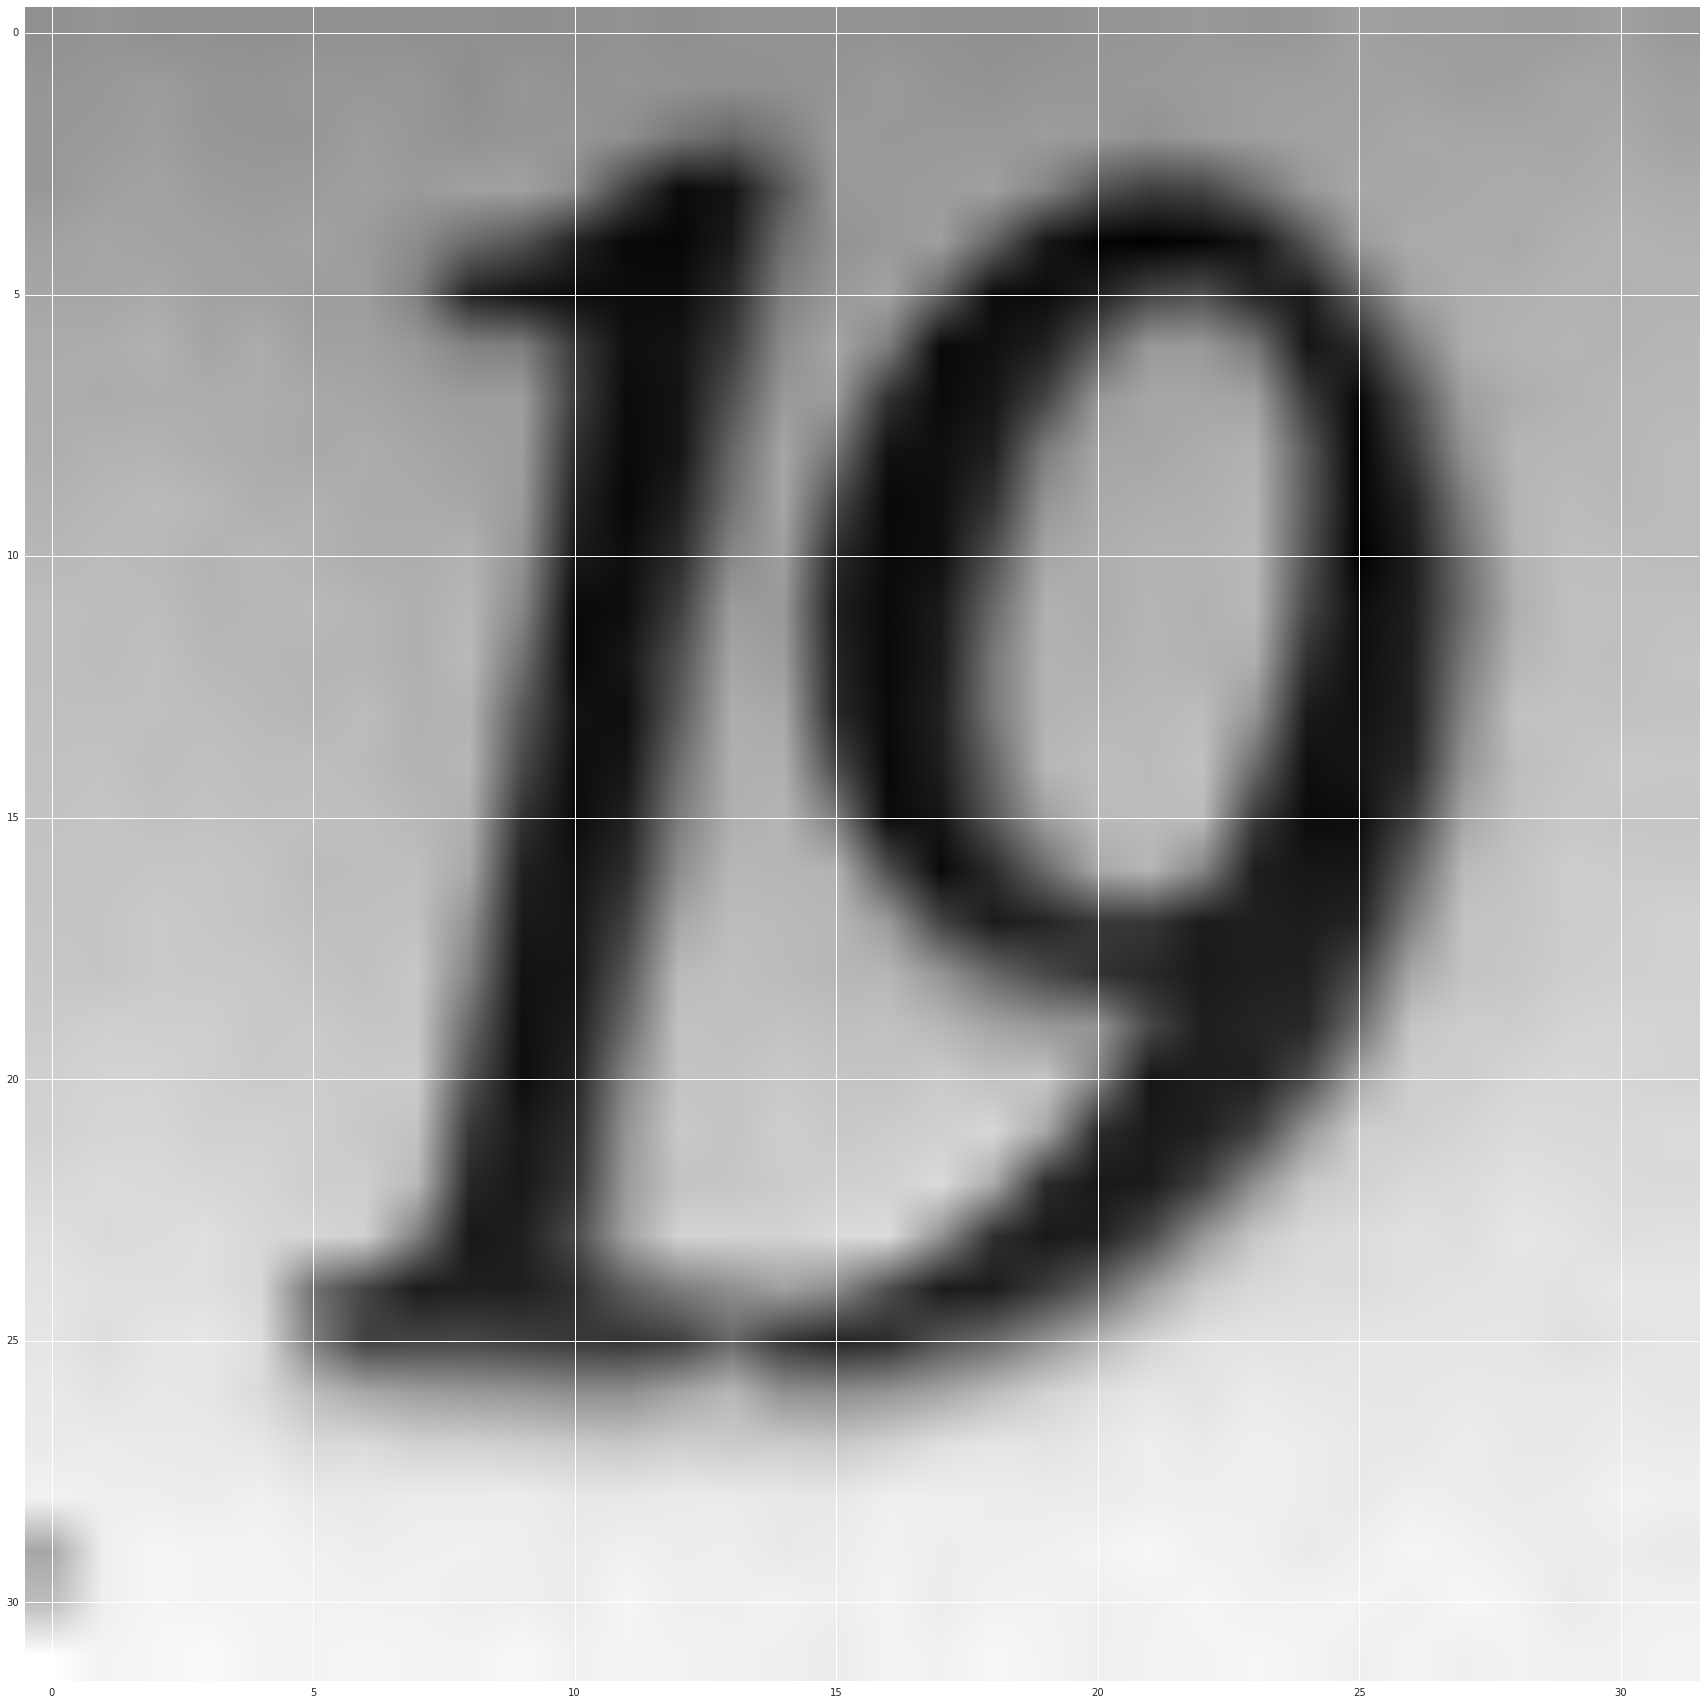

In [171]:
img_index = 0
test_img = []
for y in xrange(len(house_train_dataset_org[img_index])):
    line = []
    test_img.append(line)
    for x in xrange(len(house_train_dataset_org[img_index][y])):
        line.append(house_train_dataset_org[img_index][y][x][0])


imgplot2 = plt.imshow(test_img, cmap='gray')
print (str(house_train_labels_org[img_index]))

In [132]:
image_size = 32
batch_size = 16
num_labels = 11
num_channels = 1

patch_size = 5
depth_1 = 16
depth_2 = depth_1 * 2
depth_3 = 64 #depth_2 * 3

num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    
    tf_train_labels = tf.placeholder(
        tf.int32, shape=(batch_size, 6))
    
    tf_valid_dataset = tf.constant(house_valid_dataset_org)
    tf_test_dataset = tf.constant(house_test_dataset_org)
    
    final_image_size = output_size_pool(input_size=image_size,
                                        conv_filter_size=5, pool_filter_size=2,
                                        padding='same', conv_stride=1,
                                        pool_stride=2)

    conv1_w = weight_variable([patch_size, patch_size, num_channels, depth_1])
    conv1_b = bias_variable(tf.ones([depth_1]) / num_labels)

    conv2_w = weight_variable([patch_size, patch_size, depth_1, depth_2])
    conv2_b = bias_variable(tf.ones([depth_2]) / num_labels)

    conv3_w = weight_variable([patch_size, patch_size, depth_2, depth_3])
    conv3_b = bias_variable(tf.ones([depth_3]) / num_labels)

    fc_w = weight_variable([final_image_size * final_image_size * depth_3, num_hidden])
    fc_b = bias_variable(tf.ones([num_hidden]) / num_labels)

    logits1_weights = weight_variable([num_hidden, num_labels])
    logits1_biases = tf.Variable(tf.zeros([num_labels]) / num_labels)
    
    logits2_weights = weight_variable([num_hidden, num_labels])
    logits2_biases = tf.Variable(tf.zeros([num_labels]) / num_labels)
    
    logits3_weights = weight_variable([num_hidden, num_labels])
    logits3_biases = tf.Variable(tf.zeros([num_labels]) / num_labels)
    
    logits4_weights = weight_variable([num_hidden, num_labels])
    logits4_biases = tf.Variable(tf.zeros([num_labels]) / num_labels)
    
    logits5_weights = weight_variable([num_hidden, num_labels])
    logits5_biases = tf.Variable(tf.zeros([num_labels]) / num_labels)
    
    def model(data, keep_prob):
        conv_1 = conv_layer1(data, conv1_w, conv1_b)
        conv_2 = conv_layer2(conv_1, conv2_w, conv2_b)
        conv_3 = conv_layer3(conv_2, conv3_w, conv3_b)
        fc = full_conn(conv_3, fc_w, fc_b, keep_prob)
        
        logits_1 = tf.matmul(fc, logits1_weights) + logits1_biases
        logits_2 = tf.matmul(fc, logits2_weights) + logits2_biases
        logits_3 = tf.matmul(fc, logits3_weights) + logits3_biases
        logits_4 = tf.matmul(fc, logits4_weights) + logits4_biases
        logits_5 = tf.matmul(fc, logits5_weights) + logits5_biases
        
        return [logits_1, logits_2, logits_3, logits_4, logits_5]
    
    [logits_1, logits_2, logits_3, logits_4, logits_5] = model(
        tf_train_dataset, 0.9)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:, 1], logits=logits_1)) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:, 2], logits=logits_2)) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:, 3], logits=logits_3)) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:, 4], logits=logits_4)) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:, 5], logits=logits_5))
        
    global_step = tf.Variable(0)
    start_learning_rate = 0.05
    learning_rate = tf.train.exponential_decay(
        start_learning_rate, global_step, 10000, 0.96)
    
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(
        loss, global_step=global_step)
    
    def softmax(dataset):
        return tf.stack([
            tf.nn.softmax(model(dataset, 1.0)[0]),
            tf.nn.softmax(model(dataset, 1.0)[1]),
            tf.nn.softmax(model(dataset, 1.0)[2]),
            tf.nn.softmax(model(dataset, 1.0)[3]),
            tf.nn.softmax(model(dataset, 1.0)[4])])
    
    train_prediction = softmax(tf_train_dataset)
    valid_prediction = softmax(tf_valid_dataset)
    test_prediction = softmax(tf_test_dataset)
    
    saver = tf.train.Saver()
    
    #tf_acc = 100 * tf.reduce_mean(
    #    tf.to_float(tf.equal(tf.argmax(train_prediction, 1),
    #                         tf.argmax(tf_train_labels, 1))))
    

In [133]:
num_steps = 33401 # 12500 # 


#house_train_dataset_org.shape, house_train_labels_org.shape)
#print('Validation set', house_valid_dataset_org.shape, house_valid_labels_org.shape)
#print('Test set', house_test_dataset_org.shape, house_test_labels_org.shape)
def accuracy(predictions, labels):

  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])



history = [(0, np.nan, 10)]
with tf.Session(graph=graph) as session:

  tf.global_variables_initializer().run()
  
  # print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (house_train_labels_org.shape[0] - batch_size)
    batch_data = house_train_dataset_org[offset:(offset + batch_size), :, :, :]
    batch_labels = house_train_labels_org[offset:(offset + batch_size), :]

    feed_dict = {
        tf_train_dataset : batch_data,
        tf_train_labels : batch_labels
    }
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    # train_writer.add_summary(summary)
    
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), house_valid_labels_org[:,1:6]))
      
      # history.append((step, l, acc))
  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), house_test_labels_org[:,1:6]))
    
  save_path = saver.save(session, "./model/model_house.ckpt")
  print('Save model to ' + save_path)

Minibatch loss at step 0: 56.979530
Minibatch accuracy: 3.8%
Validation accuracy: 53.7%
Minibatch loss at step 100: 5.949882
Minibatch accuracy: 60.0%
Validation accuracy: 54.8%
Minibatch loss at step 200: 5.018436
Minibatch accuracy: 67.5%
Validation accuracy: 55.5%
Minibatch loss at step 300: 5.825909
Minibatch accuracy: 58.8%
Validation accuracy: 57.6%
Minibatch loss at step 400: 5.283907
Minibatch accuracy: 63.8%
Validation accuracy: 58.4%
Minibatch loss at step 500: 4.240598
Minibatch accuracy: 73.8%
Validation accuracy: 59.9%
Minibatch loss at step 600: 4.590680
Minibatch accuracy: 75.0%
Validation accuracy: 61.6%
Minibatch loss at step 700: 3.543653
Minibatch accuracy: 78.8%
Validation accuracy: 62.9%
Minibatch loss at step 800: 4.885110
Minibatch accuracy: 70.0%
Validation accuracy: 63.8%
Minibatch loss at step 900: 4.576722
Minibatch accuracy: 72.5%
Validation accuracy: 66.1%
Minibatch loss at step 1000: 4.902843
Minibatch accuracy: 73.8%
Validation accuracy: 65.1%
Minibatch l

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**
The training/testing input data is 32x32 pixels images wich contains numbers. The output is 5 numbers correspond to each number on image. So my model can recognize only 5-digit number. If number contains less then 5 -digits all other digits will be 10 (empty cell). Model test accuracy is 90.7%

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**
I added more logits and change dropouts.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**
The initial accuracity result was 52.0%. At the end it was improved to 88.4%. My model classyfing correclty most of the numbers. Some images are difficult to recognize even to me (because of shodows etc). I assume 90% accuracity it good for given data set.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

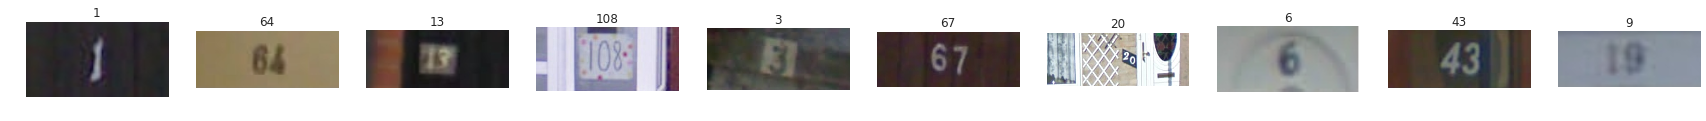

In [143]:
sample = np.random.randint(0, house_test_labels_org.shape[0], size=10)

plt.rcParams['figure.figsize'] = (30.0, 30.0)
fig, ax = plt.subplots(nrows=1, ncols=10)

i = 0
for num in sample:
    numbers = str(num + 1) + '.png'
    fullname = os.path.join('./data/test', numbers)
    im = Image.open(fullname)
    
    digits = ''
    for k in np.arange(house_test_labels_org[num, 0]):
        digits += str(house_test_labels_org[num, k + 1])
    
    ax[i].axis('off')
    ax[i].set_title(digits, loc='center')
    ax[i].imshow(im)
    
    i += 1


In [170]:
batch_data = np.ndarray([batch_size,32,32,1], dtype='float32')
batch_labels = np.ones([batch_size,6], dtype=int)

i = 0
for num in sample:
    batch_data[i] = house_test_dataset_org[num]
    batch_labels[i] = house_test_labels_org[num]
    i += 1

feed_dict = {
    tf_train_dataset : batch_data,
    tf_train_labels : batch_labels
}

with tf.Session(graph=graph) as session:
    saver.restore(session, './model/model_house.ckpt')
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    print('Accuracy: %.1f%%' % accuracy(predictions[:,:10,:], batch_labels[:10,1:6]))

result = np.argmax(predictions[:,:10,:], 2).T

for p in range(len(result)):
    digits = ''
    for k in np.arange(house_test_labels_org[sample[p], 0]):
        digits += str(house_test_labels_org[sample[p], k + 1])
        
    print ("Number on the picture: " + digits)
    pred_digits = ''
    for k in range(len(result[p])):
        if result[p][k] < 10:
            pred_digits += str(result[p][k])
    print ("Predicted: " + pred_digits)
    if digits == pred_digits:
        print ("OK")
    else:
        print ("Wrong")
    print ("")

Accuracy: 94.0%
Number on the picture: 1
Predicted: 7
Wrong

Number on the picture: 64
Predicted: 64
OK

Number on the picture: 13
Predicted: 13
OK

Number on the picture: 108
Predicted: 108
OK

Number on the picture: 3
Predicted: 3
OK

Number on the picture: 67
Predicted: 67
OK

Number on the picture: 20
Predicted: 46
Wrong

Number on the picture: 6
Predicted: 6
OK

Number on the picture: 43
Predicted: 43
OK

Number on the picture: 9
Predicted: 9
OK



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**
On the first picture I have number 1. The predicted number is 7. That is wrong. Even for people some times it's hard to recognize 1 versus 7. But this picture has clear shape of 1.

Next picture has number 20. The model faild to recognize it and predicted 46. This example has a small size number and it's hard to classify number for me as well.

All other pictures was classified correctly. Numbers 13, 108 and 43 have multi-color background and model was able to classify them.

The last number was labeled as 9. But on the picture I can see 19, model was not able to find '1' digit in the picture. So this is false positive example.

The accuracy is 94.0%.


### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**
My model able to classify realistic dataset very well. The last random test sample show accuracy 94%. Two numbers were not recognized correclty. But as I mention previousle one picture has bad quality.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**
My original implementation was designed with number localization and it work good. One of the impovement that can help is to do preprocess ing of image and use some filters like gaussian/wawes/etc...

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.